In [1]:
import shutil
import os
import nibabel
import pydicom
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import h5py
from skimage import exposure

In [63]:
#adding another data_path when code is not excecuted on Google Colab

if 'data_path' not in locals():
    data_path = "../../data/"


# Pfad zum Ordner in dem Patientendaten liegen
#SOURCE_PATH=data_path+"/CSE_Projekt_Meniskus/Neural_Network/MRI_raw_data/"
SOURCE_PATH= data_path + "raw_data/InVivo/T1_resized"

# Pfad zum Ordner in dem Trainings-, Validierungs- und Testdaten in Form eines .h5py-Files gespeichert werden
#BASE_PATH = data_path+"/CSE_Projekt_Meniskus/Neural_Network/Training_data/"
BASE_PATH = data_path + "training_data/InVivo/"

# Anzahl der Slices in einer MRT-Aufnahme
VOLUME_SLICES = 384

# Größe einer Slice -> IMG_SIZE x IMG_SIZE
IMG_SIZE = 384
IMG_SIZE_2 = 72

# Anzahl der Slices für einen Batch
SLICES_PER_BATCH=int(16)

# Anzahl der Batches pro Knie -> 160/16 = 10
folders_per_patient=int(VOLUME_SLICES/SLICES_PER_BATCH)

# Anzahl an Patienten mit denen UNet trainiert werden soll
N_PATIENTS=10

# Namen für Training-, Valdidierungs- und Test-Files
STRUCT = "InVivo_resized_turned"
SEG = 1

TRAIN_FILE="MenisKI21_Training_"+str(N_PATIENTS)+"_"+STRUCT+".h5"
TEST_FILE="MenisKI21_Test_"+str(N_PATIENTS)+"_"+STRUCT+".h5"
PREDICTION_FILE="MenisKI21_Prediction_"+str(N_PATIENTS)+"_"+STRUCT+".h5"

In [64]:
# Delete existing files
try:
    os.remove(BASE_PATH+TRAIN_FILE)
    print("Training file deleted")
except OSError:
    pass

try:
    os.remove(BASE_PATH+TEST_FILE)
    print("Test file deleted")
except OSError:
    pass

try:
    os.remove(BASE_PATH+PREDICTION_FILE)
    print("Prediction file deleted")
except OSError:
    pass

Training file deleted
Test file deleted
Prediction file deleted


In [65]:
# Finde alles Ordner in denen DICOM-Imageseries liegen und alle dazugehörigen NIFTI-Files (Segmentierungen)
patients=[ f.path for f in os.scandir(SOURCE_PATH) if f.is_dir() ]
patients.sort()
filennames_dcm=[]
filennames_seg=[]
for name in patients:
  temp=name
  if not not next(os.scandir(temp), None):
    filennames_dcm.append(temp)
    temp=name+ "/seg/"
    #temp=name+ "/SEG_sagDESS_ScreenedTackCSE_L/"
    filennames_seg.append(temp)

In [66]:
# Splitte in Trainings-, Validierungs- und Testdaten (random_state damit aufsplitten gleich bleibt)
X_train, X_test, Y_train, Y_test = train_test_split(filennames_dcm,filennames_seg,test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.25, random_state=5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


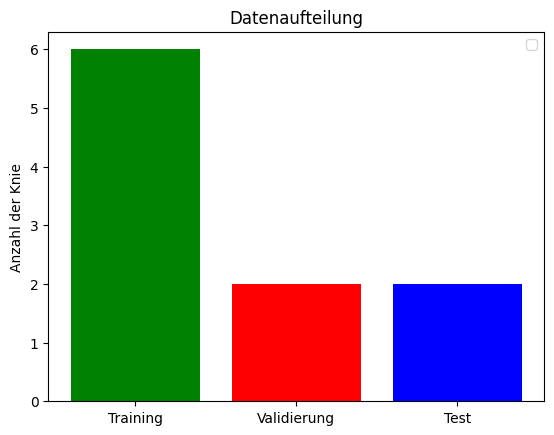

In [67]:
# Plotte die Datenaufteilung
def showDataLayout(X_train,X_val,X_test):
  plt.bar(["Training","Validierung","Test"],
  [len(X_train), len(X_val), len(X_test)], align='center',color=[ 'green','red', 'blue'])
  plt.legend()

  plt.ylabel('Anzahl der Knie')
  plt.title('Datenaufteilung')
  plt.show()
    
showDataLayout(X_train,X_val,X_test)

In [72]:
# Hilfsfunktionen aus https://gist.github.com/dgobbi/ab71f5128aa43f0d33a41775cb2bcca6

def create_affine(ipp, iop, ps):
    """Generate a NIFTI affine matrix from DICOM IPP and IOP attributes.
    The ipp (ImagePositionPatient) parameter should an Nx3 array, and
    the iop (ImageOrientationPatient) parameter should be Nx6, where
    N is the number of DICOM slices in the series.
    The return values are the NIFTI affine matrix and the NIFTI pixdim.
    Note the the output will use DICOM anatomical coordinates:
    x increases towards the left, y increases towards the back.
    """
    # solve Ax = b where x is slope, intecept
    n = ipp.shape[0]
    A = np.column_stack([np.arange(n), np.ones(n)])
    x, r, rank, s = np.linalg.lstsq(A, ipp, rcond=None)
    # round small values to zero
    x[(np.abs(x) < 1e-6)] = 0.0
    vec = x[0,:] # slope
    pos = x[1,:] # intercept

    # pixel spacing should be the same for all image
    spacing = np.ones(3)
    spacing[0:2] = ps[0,:]
    if np.sum(np.abs(ps - spacing[0:2])) > spacing[0]*1e-6:
        sys.stderr.write("Pixel spacing is inconsistent!\n");

    # compute slice spacing
    spacing[2] = np.round(np.sqrt(np.sum(np.square(vec))), 7)

    # get the orientation
    iop_average = np.mean(iop, axis=0)
    u = iop_average[0:3]
    u /= np.sqrt(np.sum(np.square(u)))
    v = iop_average[3:6]
    v /= np.sqrt(np.sum(np.square(v)))

    # round small values to zero
    u[(np.abs(u) < 1e-6)] = 0.0
    v[(np.abs(v) < 1e-6)] = 0.0

    # create the matrix
    mat = np.eye(4)
    mat[0:3,0] = u*spacing[0]
    mat[0:3,1] = v*spacing[1]
    mat[0:3,2] = vec
    mat[0:3,3] = pos

    # check whether slice vec is orthogonal to iop vectors
    dv = np.dot(vec, np.cross(u, v))
    qfac = np.sign(dv)
    if np.abs(qfac*dv - spacing[2]) > 1e-6:
        sys.stderr.write("Non-orthogonal volume!\n");

    # compute the nifti pixdim array
    pixdim = np.hstack([np.array(qfac), spacing])

    return mat, pixdim

def get_attributes_dcm(series):
    """Load a series of dicom files and get DICOM IPP and IOP attributes.
    The ps (PixelSpacing) parameter is an Nx2 array,
    the ipp (ImagePositionPatient) parameter is an Nx3 array and
    the iop (ImageOrientationPatient) parameter is Nx6, where
    N is the number of DICOM slices in the series.
    """
    n = len(series)
    ps = np.empty((n,2), dtype=np.float64)
    ipp = np.empty((n,3), dtype=np.float64)
    iop = np.empty((n,6), dtype=np.float64)
    for i, ds in enumerate(series):
        ps[i,:] = series[i].PixelSpacing
        ipp[i,:] = series[i].ImagePositionPatient
        iop[i,:] = series[i].ImageOrientationPatient
    return ps,ipp,iop

def load_dicom_series(files):
    """Load a series of dicom files and return a list of datasets.
    The resulting list will be sorted by InstanceNumber.
    """
    # start by sorting filenames lexically
    files.sort()

    # create list of tuples (InstanceNumber, DataSet)
    dataset_list = []
    for f in files:
        ds = pydicom.dcmread(f)
        try:
            i = int(ds.InstanceNumber)
        except (AttributeError, ValueError):
            i = -1
        dataset_list.append( (i, ds) )

    # sort by InstanceNumber (the first element of each tuple)
    dataset_list.sort(key=lambda t: t[0])

    # get the dataset from each tuple
    series = [t[1] for t in dataset_list]

    return series

def find_dicom_files(path):
    """Search for DICOM files at the provided location.
    """
    if os.path.isdir(path):
        # check for common DICOM suffixes
        for ext in ("*.dcm", "*.DCM", "*.dc", "*.DC", "*.IMG"):
            pattern = os.path.join(path, ext)
            files = glob.glob(pattern)
            if files:
                break
        # if no files with DICOM suffix are found, get all files
        if not files:
            pattern = os.path.join(path, "*")
            contents = glob.glob(pattern)
            files = [f for f in contents if os.path.isfile(f)]
    else:
        sys.stderr.write("Cannot open %s\n" % (path,))
        return []
    if not files:
        sys.stderr.write("No files found")
    return files

def preprocess_data_dcm(source):
    """Preprocessing Funktion MRT-Aufnahmen. Source gibt den Pfad zum Ordner an, 
    in denen die DICOM-Daten eines Knies liegen. DICOMs werden geladen und in 
    Array gespeichert (Float32 für Tensorflow). Orientierung wird überprüft und 
    Werte auf Intervall [0,1] normiert. Rückgabe ist 3D-Array.
    """
    # DICOM-Image Series einlesen 
    files =find_dicom_files(source)
    files.sort()
    slices= load_dicom_series(files)

    # Bestimme Orientierung der MRT-Aufnahme
    ps,ipp,iop=get_attributes_dcm(slices)
    affine, pixdim = create_affine(ipp, iop, ps)

    # Überprüfe Orientierung -> falls anders kann in ITK-Snap über tools -> reorient Image und unter new Orienation PSR 
    # eintragen und apply drücken. (Es muss erst DICOM Image Series geladen werden, dann Segmentierung öffnen)
    if not nibabel.aff2axcodes(affine)==('A', 'I', 'R'):
        print("Given Orientation is not covered by this function!!!!")
    temp = np.array([s.pixel_array for s in slices],dtype=('float32'))

    # Überprüfe, ob die Dimensionen stimmen -> Array 160 x 384 x 384
    # if not np.shape(temp)==(VOLUME_SLICES,IMG_SIZE,IMG_SIZE):
    #     print("DICOM-series has not the right shape -> Resizing")
    #     new=np.zeros((VOLUME_SLICES,IMG_SIZE,IMG_SIZE))
    #     for i in range (VOLUME_SLICES):
    #         new[i,:,:]=cv2.resize(temp, (IMG_SIZE, IMG_SIZE))
    #     temp=new

     #skalieren auf [0,1]
    temp = temp / np.max(temp, axis=(1, 2), keepdims=True)
     # Erhöhung des Kontrasts in jeder Slice
    temp = [exposure.equalize_adapthist(s, kernel_size=[24, 24]) for s in temp]
    temp = np.array(temp)

    #drehen in richtige richtung

    while np.shape(temp)[0] > 72:
        temp = np.delete(temp, np.shape(temp)[0]-1, 0)

    temp =  np.transpose(temp, (2, 0, 1))
    return temp
    
    
def preprocess_data_seg(source):
    """Preprocessing Funktion NIFTI-Segmenierugen. Source gibt den Pfad zum 
    Ordner an, in denen Segmentierungen eines Knies liegen. NIFTI-File wird 
    geladen und in Array gespeichert (Float32 für Tensorflow). Orientierung wird
    überprüft und ungenutzte Segmentierungen gelöscht. Meniskus medial hat den 
    Wert 1 und Meniskus lateral den Wert 2. Rückgabe ist 3D-Array.
    """ 
    # Finde NIFTI-File in Ordner 
    seg_file = [f for f in os.listdir(source) if f.endswith('.nii.gz') or f.endswith('.nii')]
    # NIFTI-Segmetnierung einlesen
    nifti_image = nibabel.load(source+seg_file[0])
    
    # Orientierung überprüfen
    if not nibabel.aff2axcodes(nifti_image.affine)==('A','I','L'):
        print("Given Orientation is not covered by this function!!!!")

    # Array aus Datenstruktur erhalten
    image = nifti_image.get_fdata()
    
    # NIFTI-File zum DICOM-File orientieren -> z-Achse umdrehen und x- mit y-Achse tauschen
    #temp=np.flipud(image.T)
    temp = np.array(image.T)


    # Überprüfe, ob die Dimensionen stimmen -> Array 160 x 384 x 384
    # if not np.shape(temp)==(VOLUME_SLICES,IMG_SIZE,IMG_SIZE):
    #     print("DICOM-series has not the right shape -> Resizing")
    #     new=np.zeros((VOLUME_SLICES,IMG_SIZE,IMG_SIZE))
    #     for i in range (VOLUME_SLICES):
    #         new[i,:,:]=cv2.resize(temp, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_NEAREST_EXACT)
    #     temp=new

    # Entferne nicht benötigte Segmentierungen
    temp[temp > SEG ] = 0 # -> Hintergrund
    temp[temp < SEG] = 0 # -> Innenmeniskus (medialis)
    temp[temp == SEG] = 1 # -> Außenmeniskus (lateral)
    
    # Float32 für Tensorflow
    temp = temp.astype('float32')

    #drehen in richtige Richtung
    while np.shape(temp)[0] > 72:
        temp = np.delete(temp, np.shape(temp)[0]-1, 0)
    shape = np.shape(temp)

    temp =  np.transpose(temp, (2, 0, 1))

    return temp       

In [73]:
# Erstelle .h5py-File für Vorhersage, dabei ist unter jedem Key die komplette MRT-Aufnahme gespeichert
with h5py.File(BASE_PATH+PREDICTION_FILE, 'w') as hf:   
  for i, (dicom,mask) in enumerate(zip(X_test,Y_test)):
      # Speichere MRT-Aufnahme
      hf.create_dataset("MenisKI21_Test_"+str(i+1).rjust(4, '0')+"_dcm",  data=preprocess_data_dcm(dicom))
      # Speichere Segmentierung
      hf.create_dataset("MenisKI21_Test_"+str(i+1).rjust(4, '0')+"_seg",  data=preprocess_data_seg(mask))

Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!


In [74]:
# Erstelle .h5py-File für Test, dabei ist unter jedem Key nur ein Batch gespeichert
with h5py.File(BASE_PATH+TEST_FILE, 'w') as hf:   
  for i, (dicom,mask) in enumerate(zip(X_test,Y_test)):
      # Erstelle 3D-Arrays für MRT-Aufnahme und Segmentierung mit Preprocess-Funktion
      temp_dcm=preprocess_data_dcm(dicom)
      temp_seg=preprocess_data_seg(mask)

      # Mische Slices zufällt durch -> Hintergrund: da nur ein Teil eines kompletten
      # Knies in einem Batch gespeichert ist, würde es so viel Batches geben, in 
      # denen keine Segmentierung enthalten ist. Durch das durchmischnen soll erreicht
      # werden, dass möglichst in jedem Batch Segmentierungen enthalten sind.
      temp_dcm, temp_seg = shuffle(temp_dcm, temp_seg, random_state=0)


      # Splitte Array auf -> Jedes Knie wird in 10 Teile aufgeplittet
      temp_dcm_split=np.split(temp_dcm,len(temp_dcm)/SLICES_PER_BATCH)
      temp_seg_split=np.split(temp_seg,len(temp_seg)/SLICES_PER_BATCH)

      # Speichere Batches ab
      for j in range(len(temp_seg_split)):
        key_target="MenisKI21_Test_"+str(j+1+i*folders_per_patient).rjust(4, '0')+"_dcm"
        hf.create_dataset(key_target,  data=temp_dcm_split[j])
        key_target="MenisKI21_Test_"+str(j+1+i*folders_per_patient).rjust(4, '0')+"_seg"
        hf.create_dataset(key_target,  data=temp_seg_split[j])

Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!


In [75]:
# Erstelle .h5py-File für Training (mit Validierungsdaten), dabei ist unter jedem Key nur ein Batch gespeichert
with h5py.File(BASE_PATH+TRAIN_FILE, 'w') as hf:   
  for i, (dicom,mask) in enumerate(zip(X_train,Y_train)):
      # Erstelle 3D-Arrays für MRT-Aufnahme und Segmentierung mit Preprocess-Funktion
      temp_dcm=preprocess_data_dcm(dicom)
      temp_seg=preprocess_data_seg(mask)

      # Mische Slices zufällt durch -> Hintergrund: da nur ein Teil eines kompletten
      # Knies in einem Batch gespeichert ist, würde es so viel Batches geben, in 
      # denen keine Segmentierung enthalten ist. Durch das durchmischnen soll erreicht
      # werden, dass möglichst in jedem Batch Segmentierungen enthalten sind.
      temp_dcm, temp_seg = shuffle(temp_dcm, temp_seg, random_state=0)

      # Splitte Array auf -> Jedes Knie wird in 10 Teile aufgeplittet
      temp_dcm_split=np.split(temp_dcm,len(temp_dcm)/SLICES_PER_BATCH)
      temp_seg_split=np.split(temp_seg,len(temp_seg)/SLICES_PER_BATCH)

      # Speichere Batches ab
      for j in range(len(temp_seg_split)):
        key_target="MenisKI21_Training_"+str(j+1+i*folders_per_patient).rjust(4, '0')+"_dcm"
        hf.create_dataset(key_target,  data=temp_dcm_split[j])
        key_target="MenisKI21_Training_"+str(j+1+i*folders_per_patient).rjust(4, '0')+"_seg"
        hf.create_dataset(key_target,  data=temp_seg_split[j])


  for i, (dicom,mask) in enumerate(zip(X_val,Y_val)):
      # Erstelle 3D-Arrays für MRT-Aufnahme und Segmentierung mit Preprocess-Funktion
      temp_dcm=preprocess_data_dcm(dicom)
      temp_seg=preprocess_data_seg(mask)

      # Mische Slices zufällt durch -> Hintergrund: da nur ein Teil eines kompletten
      # Knies in einem Batch gespeichert ist, würde es so viel Batches geben, in 
      # denen keine Segmentierung enthalten ist. Durch das durchmischnen soll erreicht
      # werden, dass möglichst in jedem Batch Segmentierungen enthalten sind.
      temp_dcm, temp_seg = shuffle(temp_dcm, temp_seg, random_state=0)

      # Splitte Array auf -> Jedes Knie wird in 10 Teile aufgeplittet
      temp_dcm_split=np.split(temp_dcm,len(temp_dcm)/SLICES_PER_BATCH)
      temp_seg_split=np.split(temp_seg,len(temp_seg)/SLICES_PER_BATCH)

      # Speichere Batches ab
      for j in range(len(temp_seg_split)):
        key_target="MenisKI21_Validation_"+str(j+1+i*folders_per_patient).rjust(4, '0')+"_dcm"
        hf.create_dataset(key_target,  data=temp_dcm_split[j])
        key_target="MenisKI21_Validation_"+str(j+1+i*folders_per_patient).rjust(4, '0')+"_seg"
        hf.create_dataset(key_target,  data=temp_seg_split[j])

Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
Given Orientation is not covered by this function!!!!
